In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Y_GT_X = 1
X_GT_Y = -1
POINT_COUNT = 15

# Generación de puntos
x_range = y_range = (0, 5)
x_lim = y_lim = x_range[1]

split_points = { Y_GT_X: [], X_GT_Y: []}
points_per_class = { Y_GT_X: POINT_COUNT, X_GT_Y: POINT_COUNT }

rng = np.random.default_rng()
klass_pred = { Y_GT_X: '>', X_GT_Y: '<' }

def klass_range(x, klass):
    return (0, x) if klass == X_GT_Y else (x, y_lim)

def generate_points(n, x_range, y_range, klass):
    data = rng.uniform(x_range[0], x_range[1], size=n)
    return list(map(lambda x: (x, rng.uniform(*klass_range(x, klass)), klass), data))

for klass, n in points_per_class.items():
    split_points[klass] = generate_points(n, x_range, y_range, klass)

points = split_points[Y_GT_X] + split_points[X_GT_Y]
df = pd.DataFrame(points, columns=['x', 'y', 'class'])
df.head()

,x,y,class
0,2.899819,4.877617,1
1,0.209157,4.078734,1
2,2.739024,4.301011,1
3,4.361434,4.797911,1
4,0.254129,0.273448,1


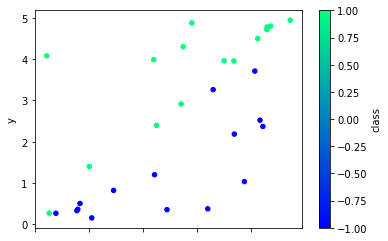

In [48]:
df.plot.scatter('x', 'y', c='class', colormap='winter')
xs = np.linspace(0, 5, 1000)

In [49]:
def calculate_h(w, point):
    return sum([w[j] * point[j] for j in range(0, len(w))])


def calculate_o(h):
    return 1 if h > 0 else -1


def calculate_error(data, w):
    err = 0
    for index, row in data.iterrows():
        h = calculate_h(w, row)
        o = calculate_o(h)
        err += abs(row['class'] - o)
    return err


def get_weights(data, eta=0.1, iterations=1000, stdout=False):
    i = 0
    w = [0 for i in range(len(data.loc[0]) - 1)]
    w_min = w
    error = 1
    error_min = len(df)
    threshold = w[0]  # TODO: ask
    
    while error > 0 and i < iterations:
        random_index = rng.integers(0, len(data))
        point = data.iloc[random_index]
        h = calculate_h(w, point)
        o = calculate_o(h)
        delta_w = eta * (point['class'] - o) * point[0:len(point) - 1]
        w += delta_w
        error = calculate_error(data, w)
        if error < error_min:
            error_min = error
            w_min = w
        
        i += 1
        
        if stdout:
            print(f"error: {error}; point: {list(point)}; h: {h}; o: {o}; delta_w: {list(delta_w)}; w: {list(w)}")
    
    return w_min, error_min

In [50]:
ws, err_m = get_weights(df)
print(f"\n\n\n\n\n{err_m}")
print(ws)






0.0
x   -1.355553
y    1.365569
Name: 9, dtype: float64


0.9926649575275528


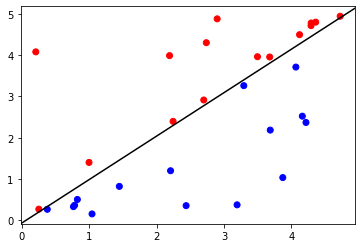

In [51]:
# w1*x + w2*y + b = 0
fig, ax = plt.subplots()
ax.scatter(list(df['x']), list(df['y']), c=list(df['class']), cmap='bwr')
yi = - ws[0] * 0 / ws[1]
yf = - ws[0] * 1 / ws[1]
print(yf)
ax.plot([0, 1], [yi, yf], color='Black', transform=ax.transAxes)

In [16]:
def classify(x, y, w):
    h = calculate_h(w, (x, y))
    o = calculate_o(h)
    return o

print(classify(1, 0.8814770326018851, ws))

-1


In [43]:
# Non-linearly separable dataset

MISMATCH_CLASS_DELTA_Y = 0.5

mismatch_points_per_class = { Y_GT_X: 3, X_GT_Y: 3 }
split_points_2 = { Y_GT_X: [], X_GT_Y: []}

def klass_range_mismatch(x, klass):
    return (x, min(x + MISMATCH_CLASS_DELTA_Y, y_lim)) if klass == X_GT_Y else (x, max(x - MISMATCH_CLASS_DELTA_Y, 0))

def get_klass_range(x, klass, mismatch):
    return klass_range(x, klass) if not mismatch else klass_range_mismatch(x, klass)

def generate_points_non_linear(n, x_range, y_range, klass, mismatch=False):
    data = rng.uniform(x_range[0], x_range[1], size=n)
    return list(map(lambda x: (x, rng.uniform(*get_klass_range(x, klass, mismatch)), klass), data))

for klass, n in points_per_class.items():
    split_points_2[klass] = generate_points_non_linear(n, x_range, y_range, klass)

for klass, n in mismatch_points_per_class.items():
    split_points_2[klass] += generate_points_non_linear(n, x_range, y_range, klass, True)

points_2 = split_points_2[Y_GT_X] + split_points_2[X_GT_Y]
df_2 = pd.DataFrame(points_2, columns=['x', 'y', 'class'])
df_2.head()

,x,y,class
0,0.368429,2.646050,1
1,3.600702,4.606227,1
2,2.133057,4.590356,1
3,2.447549,2.759760,1
4,4.279055,4.661715,1


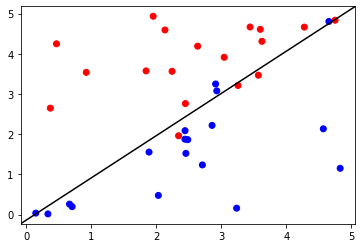

In [44]:
fig, ax = plt.subplots()
ax.scatter(list(df_2['x']), list(df_2['y']), c=list(df_2['class']), cmap='bwr')
ax.plot([0, 1], [0, 1], color='Black', transform=ax.transAxes)

In [45]:
ws_2, err_m_2 = get_weights(df_2)
print(f"\n\n\n\n\n{err_m_2}")
print(ws_2)






8.0
x   -3.313181
y    3.073255
Name: 6, dtype: float64


1.0780691297985174


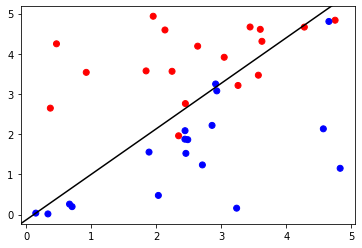

In [46]:
# w1*x + w2*y + b = 0
fig2, ax2 = plt.subplots()
ax2.scatter(list(df_2['x']), list(df_2['y']), c=list(df_2['class']), cmap='bwr')
yi_2 = - ws_2[0] * 0 / ws_2[1]
yf_2 = - ws_2[0] * 1 / ws_2[1]
print(yf_2)
ax2.plot([0, 1], [yi_2, yf_2], color='Black', transform=ax2.transAxes)